# YOLOv4-Mini Kaggle Safety Helmet Detection

DarkNet: https://github.com/AlexeyAB/darknet

Reference notebook: https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial/blob/master/YOLOv4_Training_Tutorial.ipynb

## Download Kaggle Safety Helmet Images and Annotations

https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection

In order to download Kaggle data directly into Colab, a Kaggle API token is needed:
https://www.kaggle.com/settings/account

In [1]:
#!rm -r ~/.kaggle
!mkdir ~/.kaggle

In [2]:
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

100% 1.22G/1.22G [00:49<00:00, 27.8MB/s]
100% 1.22G/1.22G [00:49<00:00, 26.4MB/s]


In [4]:
#!unzip hard-hat-detection.zip

## Downloading and Compiling Darknet on Colab

In [4]:
# Verify cuda version.
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15521, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15521 (delta 0), reused 5 (delta 0), pack-reused 15514
Receiving objects: 100% (15521/15521), 14.19 MiB | 17.68 MiB/s, done.
Resolving deltas: 100% (10412/10412), done.


In [6]:
# Enable GPU and OPENCV in Makefile.
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
!make

In [8]:
# Download pretrained weights for inference.
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [9]:
# Download partial weights for transfer learning.
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
# Download partial tiny weights for transfer learning.
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

In [ ]:
# Download pretrained tiny weights for inference.
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights

In [12]:
# Copy the downloaded data .zip file into the darknet directory.
!cp ../hard-hat-detection.zip ./

In [ ]:
# This will be unzipped into 2 folders - `images` and `annotations`.
!unzip hard-hat-detection.zip

## Python Functions to Prepare Data and Bounding Box Annotations

In [14]:
import os

from google.colab import files

import cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET

In [15]:
# Functions to convert Pascal VOC bounding boxes to YOLO format.
def xml_to_yolo_bbox(bndbox, image_size):
    # xml to yolo bounding box.
    xmin, xmax, ymin, ymax = bndbox
    # x and y mid points of the bounding box.
    x_mid = (xmin + xmax) * 0.5
    y_mid = (ymin + ymax) * 0.5
    # Height and width of the box.
    height = ymax - ymin
    width = xmax - xmin

    image_width, image_height = image_size
    image_width_inv = 1 / image_width
    image_height_inv = 1 / image_height

    x_mid = x_mid * image_width_inv
    width = width * image_width_inv
    y_mid = y_mid * image_height_inv
    height = height * image_height_inv
    return [x_mid, y_mid, width, height]

def xml_to_yolo(xml_file_path, txt_file_path, wanted_classes):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    size = root.find("size")
    img_width = int(size.find("width").text)
    img_height = int(size.find("height").text)

    output_string = ""

    for o in root.iter("object"):
        obj_class = o.find("name").text
        if obj_class in wanted_classes:
          obj_class_id = str(wanted_classes.index(obj_class))
          bndbox = o.find("bndbox")
          bndbox = [float(bndbox.find("xmin").text),
                    float(bndbox.find("xmax").text),
                    float(bndbox.find("ymin").text),
                    float(bndbox.find("ymax").text)]

          yolo_box = xml_to_yolo_bbox(bndbox, [img_width, img_height])

          output_string = output_string + obj_class_id + " "
          output_string = output_string + " ".join([str(b) for b in yolo_box])
          output_string = output_string + "\n"

    with open(txt_file_path, "w") as f:
        f.write(output_string)

In [16]:
# We need to create some files required by YOLO:
# 1. obj.names
# 2. .txt annotation files
# 3. obj.data
# 4. .cfg configuration file

# Prepare the obj.names, obj.data and .cfg files required for Yolov4 training.
wanted_classes = ["helmet", "head"]
image_extension = ".png"

# 1. obj.names
# This file contains the categories of all the objects in the dataset.
# The index of the category serves as its numerical category.
# Therefore class 0 is helmet and class 1 is head.
obj_names_output_string = ""
for wc in wanted_classes:
    obj_names_output_string = obj_names_output_string + wc + "\n"

with open("obj.names", "w") as f:
    f.write(obj_names_output_string)


# 2. .txt annotation files.
# YOLO requires that each image file has its own .txt annotation file with the
# bounding box format:
# category x_mid_point y_mid_point width height
ann_xml_file_list = os.listdir("annotations/")
image_file_list = []

# Get all image names.
for i in os.listdir("images/"):
    if i[-4:] == image_extension:
        image_file_list.append(i)

print("{} images.".format(len(image_file_list)))

# Create the .txt annotations from the .xml files.
for a in ann_xml_file_list:
    if a[-4:] == ".xml":
        file_root_name = a[:-4]
        if file_root_name + image_extension in image_file_list:
            txt_name = file_root_name + ".txt"
            xml_to_yolo(os.path.join("annotations/", a),
                        os.path.join("images/", txt_name),
                        wanted_classes)

# In addition to the annotation .txt files, we also need to explicitly specify
# the training images and test images as .txt files.

# Make the train test split.
train_image_list, test_image_list = train_test_split(image_file_list,
                                                     test_size = 0.2,
                                                     random_state = 42)
train_image_list.sort()
test_image_list.sort()
print("Train images: {}, test images: {}.".format(len(train_image_list),
                                                  len(test_image_list)))

# Make the train.txt file.
# This will contain a list of all training images.
train_txt_output_string = ""
for f in train_image_list:
    train_txt_output_string = train_txt_output_string + "images/" + f + "\n"

with open("train.txt", "w") as f:
    f.write(train_txt_output_string)

# Make the test.txt file.
# This will contain a list of all testing images.
test_txt_output_string = ""
for f in test_image_list:
    test_txt_output_string = test_txt_output_string + "images/" + f + "\n"

with open("test.txt", "w") as f:
    f.write(test_txt_output_string)

# 3. obj.data
# This file tells YOLO how many classes there are in the dataset, the paths to
# train.txt and test.txt, obj.names as well as the output location "backup".
obj_data_output_string = """classes = 2
train = train.txt
valid = test.txt
names = obj.names
backup = backup"""

with open("obj.data", "w") as f:
    f.write(obj_data_output_string)

5000 images.
Train images: 4000, test images: 1000.


In [17]:
#!cp cfg/yolov4-custom.cfg ./

In [18]:
# Next we need to create the .cfg file.
# We do not create one from scratch - rather we modify an existing one.
!cp cfg/yolov4-tiny-custom.cfg ./

In [19]:
# Modify .cfg as outlined in https://github.com/AlexeyAB/darknet.
with open("yolov4-tiny-custom.cfg", "r") as f:
    cfg_string = f.read()

cfg_string = cfg_string.split("\n")

# change line subdivisions to subdivisions=16
cfg_string[6] = "subdivisions=16"
# change line max_batches to (classes*2000, but not less than number of training
# images and not less than 6000), f.e. max_batches=6000 if you train for 3
# classes
cfg_string[19] = "max_batches=6000"
# change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
cfg_string[21] = "steps=4800,5400"
# change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional]
# before each [yolo] layer, keep in mind that it only has to be the last
# [convolutional] before each of the [yolo] layers
# change line classes=80 to your number of objects in each of 3 [yolo]-layers
# For YOLO-Mini there are only 2 [yolo] layers
cfg_string[211] = "filters=21"
cfg_string[219] = "classes=2"
cfg_string[262] = "filters=21"
cfg_string[268] = "classes=2"

cfg_string = "\n".join(cfg_string)

with open("yolov4-tiny-custom.cfg", "w") as f:
    f.write(cfg_string)

In [20]:
def imShow(path):
    image = cv2.imread(path)
    resized_image = image.copy()
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

def upload():
    uploaded = files.upload()
    for name, data in uploaded.items():
        with open(name, "wb") as f:
            f.write(data)
            print("saved file", name)

def download(path):
    files.download(path)

In [21]:
#!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg -dont_show -out_filename predictions.jpg

In [22]:
#!./darknet detector test cfg/coco.data cfg/yolov4-tiny.cfg yolov4-tiny.weights data/person.jpg -dont_show -out_filename predictions.jpg

In [23]:
#imShow("predictions.jpg")

## Transfer Learning Yolov4

In [24]:
!./darknet detector train obj.data yolov4-tiny-custom.cfg yolov4-tiny.conv.29 -dont_show -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.780272), count: 2, class_loss = 0.164348, iou_loss = 0.223113, total_loss = 0.387461 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.806890), count: 24, class_loss = 1.278914, iou_loss = 25.031565, total_loss = 26.310478 
 total_bbox = 1631820, rewritten_bbox = 0.983135 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.761415), count: 4, class_loss = 0.577022, iou_loss = 0.715538, total_loss = 1.292561 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.711701), count: 11, class_loss = 1.297081, iou_loss = 8.373890, total_loss = 9.670971 
 total_bbox = 1631835, rewritten_bbox = 0.983126 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.000000), count: 1, class_loss = 0.000031, iou_loss = 0.000000, total_loss = 0.000031 
v

## Testing the Finetuned Model

In [ ]:
!./darknet detector test obj.data yolov4-tiny-custom.cfg backup/yolov4-tiny-custom_last.weights images/hard_hat_workers10.png --dont_show --out_filename predictions.jpg

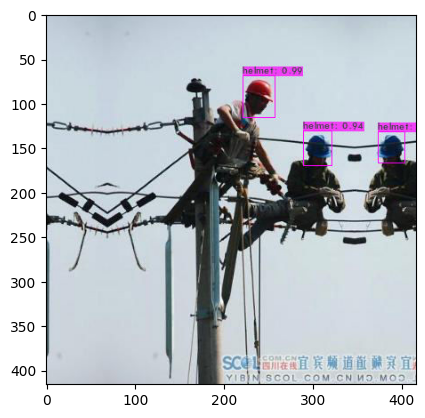

In [28]:
imShow("predictions.jpg")